# Sentiment Analysis of _Avatar: Frontiers of Pandora_ Reviews

This project aims to analyse the reviews of game called _Avatar: Frontiers of Pandora_. The reviews are taken from Metacritic website and only first 50 user reviews are scraped.

First, let's load the necessary packages and set some options for plotting.

In [1]:
%%capture
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import requests
import re
import codecs
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
import spacy
from langdetect import detect
from pyabsa import AspectTermExtraction as ATEPC
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

Next, we scrape the Metacritic website. We use only _BeautifulSoup_ and _requests_ packages for simplicity, but it would be better to use _selenium_ package, because the website has a dynamic content. With a help of RegEx we then find the reviews.

In [2]:
url = "https://www.metacritic.com/game/avatar-frontiers-of-pandora/user-reviews/?platform=pc"

header = {'User-agent': 'Mozilla/5.0'}
result = requests.get(url, headers=header)

reviews = BeautifulSoup(result.text, "html.parser")

reviews_text = re.findall("quote:\".*?\",platform", result.text)

After we have the reviews, we do some basic cleaning.

In [3]:
for i in range(len(reviews_text)):
    reviews_text[i] = codecs.decode(reviews_text[i], 'unicode-escape')
    reviews_text[i] = re.sub('quote:"', "", reviews_text[i])
    reviews_text[i] = re.sub('",platform', "", reviews_text[i])
    reviews_text[i] = re.sub("\\n", "", reviews_text[i])
    reviews_text[i] = re.sub(r"\\", "", reviews_text[i])

After inspecting the reviews, we found that some of the reviews are not in english, so we use _langdetect_ package to remove these reviews.

In [4]:
reviews_final = []
for i in range(len(reviews_text)):
    if detect(reviews_text[i]) == "en":
        reviews_final.append(reviews_text[i])

Now we can perform the sentiment analysis. First, let's get the sentiment scores for every review with a pretrained model from _nltk_ package.

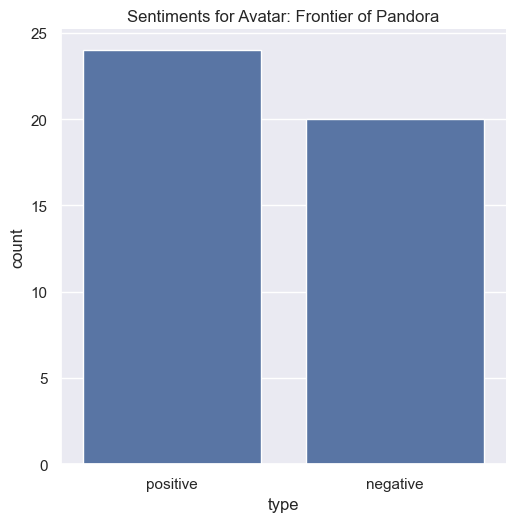

In [5]:
sentiment_model = SentimentIntensityAnalyzer()

sentiments = np.asarray([sentiment_model.polarity_scores(i)["compound"] for i in reviews_final])
sentiments_data = {"positive": np.sum(sentiments >= 0), "negative": np.sum(sentiments < 0)}

bar = sns.catplot(x = sentiments_data.keys(), y = sentiments_data.values(), kind="bar")
bar.set(title="Sentiments for Avatar: Frontier of Pandora")
bar.set_ylabels("count")
bar.set_xlabels("type")
plt.show()

We can further analyse the reviews by making wordclouds for positive and negative reviews. However, before we do so, we need to preprocess the data to get the frequency distributions. The preprocessing consists of tokenization converting the text to lower case and stopwords removal.

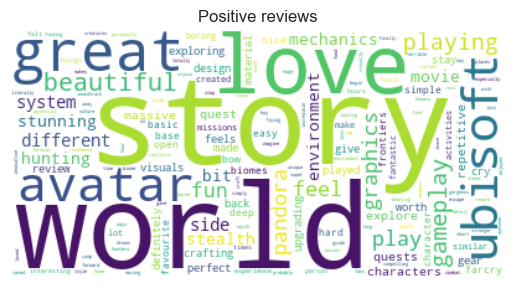

In [6]:
positive_reviews = np.asarray(reviews_final)[sentiments >= 0]
negative_reviews = np.asarray(reviews_final)[sentiments < 0]

positive_reviews = RegexpTokenizer(r"[A-Za-z]{2,}").tokenize(" ".join(positive_reviews.tolist()))
negative_reviews = RegexpTokenizer(r"[A-Za-z]{2,}").tokenize(" ".join(negative_reviews.tolist()))

positive_reviews = [i.lower() for i in positive_reviews]
negative_reviews = [i.lower() for i in negative_reviews]

positive_reviews = [i for i in positive_reviews if i not in stopwords.words() and i not in ["game", "games"]]
negative_reviews = [i for i in negative_reviews if i not in stopwords.words() and i not in ["game", "games"]]

positive_freq = FreqDist(positive_reviews)
negative_freq = FreqDist(negative_reviews)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(positive_freq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive reviews")
plt.show()

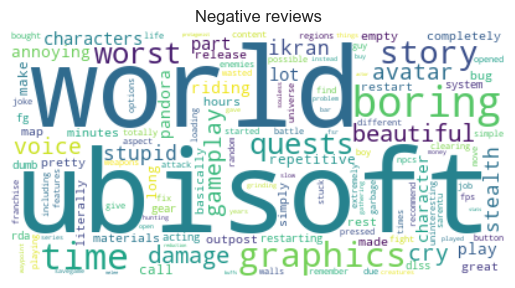

In [7]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(negative_freq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Negative reviews")
plt.show()

This already gives us some hints to what people like or dislike about the game. We can now try to perform aspect based sentiment analysis. According to theory, we should extract quintuples from the text that look like this: (e, a, so, h, t), where _e_ is the target entity, _a_ is the aspect of the entity, _so_ is the sentiment value, _h_ is the opinion holder and _t_ is the time when the opinion was expressed. This is however very hard task. We simplify the problem by ignoring the time, the opinion holder (entity is constant, because the reviews are only for one entity) and that the opinion are expressed explicitly. The solution below uses syntactic parsing and part of speech tagging to find the predetermined aspects and the sentiments (for simplcity we assume only direct non-negative opinions, e.g. "This game is bad.").

In [8]:
nlp = spacy.load("en_core_web_sm")
aspects = {"graphic": [], "graphics": [], "game": [], "gameplay": [], "story": [], "quest": [], "quests": []}
for review in reviews_final:
    parsed_sentenced = nlp(review)
    for key in aspects.keys():
        for word in parsed_sentenced:
            if word.text.lower() == key:
                if word.dep_ == "nsubj":
                    root = word.head
                    while root.text != root.head:
                        root = root.head
                    for child in root.children:
                        if child.pos_ == "ADJ":
                            aspects[key].append(child.text.lower())
                for child in word.children:
                    if child.pos_ == "ADJ":
                        aspects[key].append(child.text.lower())
aspects["graphics"] = aspects["graphics"] + aspects["graphic"]
aspects.pop("graphic")
aspects["story"] = aspects["story"] + aspects["quest"] + aspects["quests"]
aspects.pop("quest")
aspects.pop("quests");

Now we can visualise our findings.

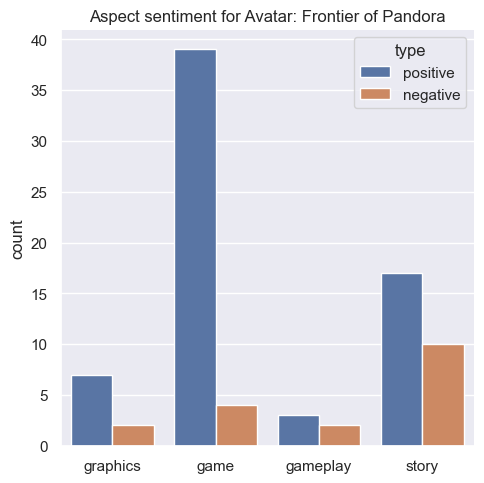

In [9]:
aspects_sentiment = dict()
for key, item in aspects.items():
    aspects_sentiment[key] = [sentiment_model.polarity_scores(key+" "+adjective)["compound"] for adjective in item]

for key, sentiments in aspects_sentiment.items():
    aspects_sentiment[key] = [np.sum(np.asarray(sentiments) >= 0), np.sum(np.asarray(sentiments) < 0)]
aspects_sentiment["type"] = ["positive", "negative"]

df_aspects_sentiment = pd.DataFrame(aspects_sentiment)
df_aspects_sentiment = pd.melt(df_aspects_sentiment, ["type"], ["graphics", "game", "gameplay", "story"], "aspect", "count")

bar = sns.catplot(data = df_aspects_sentiment, x = "aspect", y = "count", hue = "type", kind = "bar", legend_out=False)
bar.set(title="Aspect sentiment for Avatar: Frontier of Pandora")
bar.set_ylabels("count")
bar.set_xlabels("")
plt.show()

We can also use transformers based model to look for aspect sentiment, nevertheless after some testing we found that results were not optimal, so this is just an example.

In [10]:
%%capture
aspect_extractor = ATEPC.AspectExtractor('multilingual',
                                         auto_device=False,
                                         cal_perplexity=True,
                                         )

prediction = aspect_extractor.predict(reviews_final[0],
                         save_result=True,
                         print_result=True,
                         ignore_error=True,
                         )

In [11]:
print(f'{prediction["aspect"]} \n{prediction["sentiment"]} \n{prediction["confidence"]}')

['Graphic', 'gameplay', 'Quests', 'Characters'] 
['Positive', 'Positive', 'Positive', 'Negative'] 
[0.9421, 0.926, 0.8579, 0.9911]
